In [44]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from numpy import random
from numpy.random import randn
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import kf_book.book_plots as bp
from scipy.linalg import block_diag
# read from csv and save corresponding column data to variables
df = pd.read_csv('point1.csv')
# transfer unit to meter
y = df.y.div(1000)
x = df.x.div(1000)
# l = len(y)
x_mean = np.mean(x)
y_mean = np.mean(y)
process_std = 0.028
process_var = 0.028 ** 2
process_var_lateral = 0.019 **2
sensor_std = 0.077
sensor_var = 0.077 ** 2
sensor_var_lateral = 0.125 ** 2

In [45]:
x_mean

5.799013605442178

In [46]:
y_mean

4.865020408163268

In [47]:
# N = 8
# points = []
# xs = []
# ys = []
# for i in range(1, N + 1):
#     df = pd.read_csv(f'point{i}.csv')
#     # transfer unit to meter
#     y = df.y.div(1000)
#     x = df.x.div(1000)
#     # l = len(y)
#     x_mean = np.mean(x)
#     xs.append(x_mean)
#     y_mean = np.mean(y)
#     ys.append(y_mean)
#     points.append([x_mean, y_mean])

# print(f"xs: {xs}\tys: {ys}")

In [48]:
xs = [5.799013605442178, 5.677136752136748, 5.70306106870229, 5.09885606060606, 5.120082644628101, 4.572519379844961, 4.478495575221241, 2.03554054054054]
ys = [4.865020408163268, 4.234247863247866, 3.7864122137404563, 3.554515151515152, 3.1047024793388442, 2.931767441860464, 2.4959646017699106, 2.353558558558559]

In [49]:
from math import sin, cos, radians
# calculation of theoretical x and y for track assuming the first coordinate is correct
theo_x = [xs[0]]
theo_y = [ys[0]]

# 2nd point
theo_x.append(theo_x[-1])
theo_y.append(theo_y[-1] - 0.7)

# 3rd point
rad = radians(30)
theo_x.append(theo_x[-1] - 0.5 * sin(rad))
theo_y.append(theo_y[-1] - 0.5 * cos(rad))

# 4th point
rad = radians(30)
theo_x.append(theo_x[-1] - 0.5 * cos(rad))
theo_y.append(theo_y[-1] - 0.5 * sin(rad))

# 5th point
theo_x.append(theo_x[-1])
theo_y.append(theo_y[-1] - 0.5)

# 6th point
theo_x.append(theo_x[-1] - 0.5)
theo_y.append(theo_y[-1])

# 7th point
theo_x.append(theo_x[-1])
theo_y.append(theo_y[-1] - 0.6)

# 8th point
theo_x.append(theo_x[-1] - 2.5)
theo_y.append(theo_y[-1])

In [50]:
theo_x, theo_y

([5.799013605442178,
  5.799013605442178,
  5.549013605442178,
  5.116000903549958,
  5.116000903549958,
  4.616000903549958,
  4.616000903549958,
  2.116000903549958],
 [4.865020408163268,
  4.165020408163268,
  3.7320077062710486,
  3.4820077062710486,
  2.9820077062710486,
  2.9820077062710486,
  2.3820077062710485,
  2.3820077062710485])

In [103]:
# sample for xs and ys
sampleX = np.arange(xs[0], xs[-1], (xs[-1] - xs[0])/50).tolist()
samp_len = len(sampleX)
# samp_theoX = np.arange(theo_x[0], theo_x[-1], (theo_x[-1] - theo_x[0])/50).tolist()
samp_len

51

In [76]:
samp_theoX

[5.799013605442178,
 5.725353351404333,
 5.651693097366489,
 5.578032843328645,
 5.5043725892908,
 5.430712335252956,
 5.3570520812151114,
 5.283391827177267,
 5.209731573139423,
 5.136071319101578,
 5.062411065063734,
 4.98875081102589,
 4.915090556988045,
 4.841430302950201,
 4.7677700489123565,
 4.694109794874512,
 4.620449540836668,
 4.546789286798823,
 4.473129032760979,
 4.399468778723135,
 4.32580852468529,
 4.252148270647446,
 4.1784880166096015,
 4.104827762571757,
 4.031167508533913,
 3.9575072544960683,
 3.883847000458224,
 3.8101867464203796,
 3.736526492382535,
 3.662866238344691,
 3.5892059843068465,
 3.515545730269002,
 3.4418854762311577,
 3.3682252221933133,
 3.294564968155469,
 3.2209047141176246,
 3.14724446007978,
 3.073584206041936,
 2.9999239520040915,
 2.926263697966247,
 2.8526034439284027,
 2.7789431898905583,
 2.705282935852714,
 2.6316226818148696,
 2.557962427777025,
 2.484302173739181,
 2.4106419197013365,
 2.336981665663492,
 2.2633214116256477,
 2.1896611

In [77]:
l = len(xs)
sampleY = []
j = 0
for i in range(l - 1):    
    k = (ys[i+1] - ys[i])/(xs[i+1] - xs[i])
    while j < samp_len and xs[i+1] <= sampleX[j] <= xs[i]:
        sampleY.append(k * (sampleX[j] - xs[i]) + ys[i])
        j += 1
#     print(f"k for measured track = {k}, the function is:\ny = {k}*(X - {xs[i]}) + {ys[i]}")

In [54]:
samp_lenY = len(sampleY)

In [55]:
samp_lenY

50

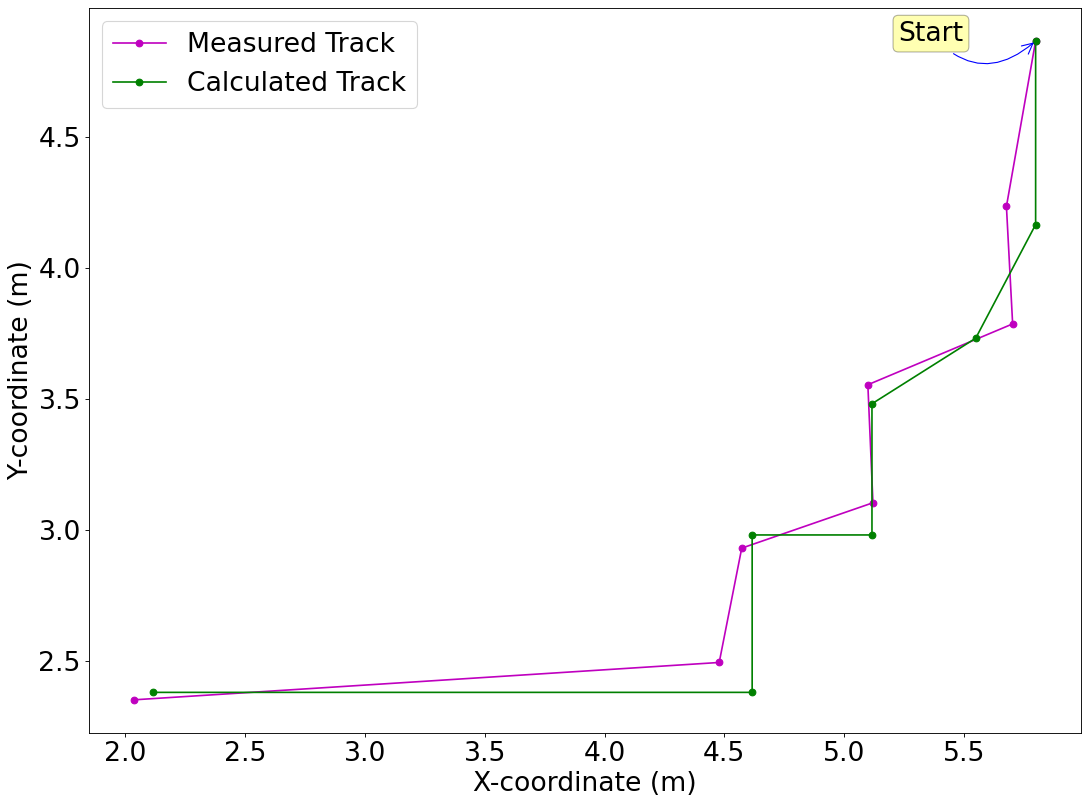

In [56]:
plt.figure(figsize=(16, 12), dpi=80)
plt.rcParams.update({'font.size': 24})
plt.xlabel("X-coordinate (m)")
plt.ylabel("Y-coordinate (m)")
plt.plot(xs, ys, '-o', color='m', label='Measured Track')
plt.plot(theo_x, theo_y, '-o', color='g', label='Calculated Track')
plt.annotate("Start", xy=(xs[0], ys[0]), xytext=(xs[0] - 100, ys[0] - 10), textcoords='offset points', ha='center', va='bottom',color='black',
         bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='blue'))
plt.legend(loc='best')
plt.savefig('track.pdf', bbox_inches='tight', dpi=400)

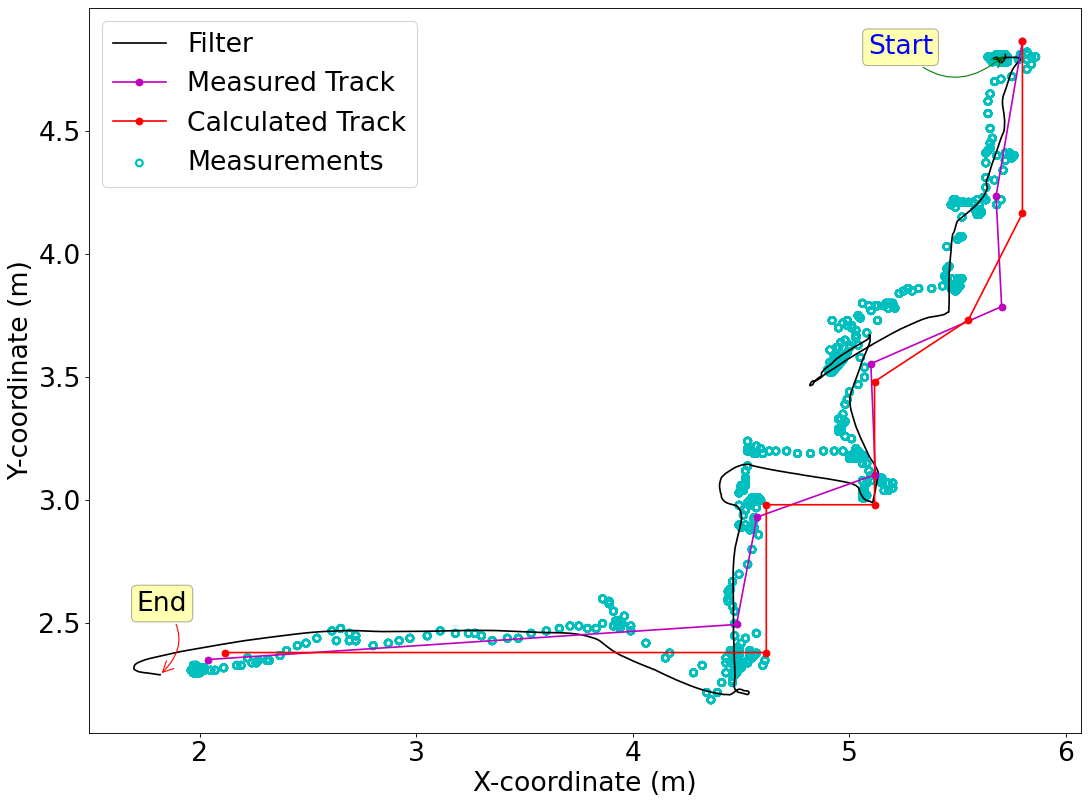

In [57]:
df1 = pd.read_csv(f'exp{1}_0107.csv')
uwb_x1 = df1.uwb_x
uwb_y1 = df1.uwb_y
vel_linear_x1 = df1['vel_linear_x'].fillna(0.0)
# first nonzero value for uwb_x
ini_index1 = uwb_x1.ne(0).idxmax()
def track():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 0.01
    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])

    tracker.R = np.array([[sensor_var, 0], [0, sensor_var_lateral]])
    q_forward = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
    q_lateral = Q_discrete_white_noise(dim=2, dt=dt, var=process_var_lateral)
    tracker.Q = block_diag(q_forward, q_lateral)
#     print(f"Q = {tracker.Q}")
    tracker.x = np.array([[uwb_x1[ini_index1], vel_linear_x1[0], uwb_y1[ini_index1], 0]]).T
    tracker.P = np.eye(4) * 0.5
    return tracker
# robot circle movement
N = len(uwb_x1[ini_index1:])
zs1 = np.array([[uwb_x1[i], uwb_y1[i]] for i in range(ini_index1, N)])

# run filter
robot_tracker = track()
# batch_filter is quite slow
mu, cov, _, _ = robot_tracker.batch_filter(zs1[ini_index1:])

# plot result
plt.figure(figsize=(16, 12), dpi=80)
plt.rcParams.update({'font.size': 24})
# c for color in plot_filter
bp.plot_filter(mu[:, 0], mu[:, 2], c='k')
bp.plot_measurements(zs1[ini_index1:, 0], zs1[ini_index1:, 1], color='c')
#     plt.title('Kalman Filter position for robot movement under remote control')
plt.xlabel("X-coordinate (m)")
plt.ylabel("Y-coordinate (m)")
# plt.annotate("Start", xy=(zs1[ini_index1][0], zs1[ini_index1][1]), xytext=(zs1[ini_index1][0] + 100, zs1[ini_index1][1] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
#          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
#          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.05', 
#                             color='green'))
# plt.annotate("End", xy=(zs1[-1][0], zs1[-1][1]), xytext=(zs1[-1][0] - 100, zs1[-1][1]), textcoords='offset points', ha='center', va='bottom',
#          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
#          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
#                             color='red'))
plt.plot(xs, ys, '-o', color='m', label='Measured Track')
plt.plot(theo_x, theo_y, '-o', color='r', label='Calculated Track')
plt.annotate("Start", xy=(mu[0][0], mu[0][2]), xytext=(mu[0][0] - 100, mu[0][2] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
         bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='green'))
plt.annotate("End", xy=(mu[-1][0], mu[-1][2]), xytext=(mu[-1][0], mu[-1][2] + 50), textcoords='offset points', ha='center', va='bottom',
         bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
                            color='red'))
plt.legend(loc='best')
# plt.savefig(f"exp1.pdf", dpi=300)

In [93]:
from math import sqrt
error = []
for j, sx in enumerate(sampleX):
    for i, m in enumerate(mu[:, 0]):
        if abs(sx - m) <= 0.001:
            error.append(sqrt((sx - m)**2 + (sampleY[j] - mu[:, 2][i])**2))
            continue

In [94]:
err_len = len(error)
err_len

107

In [95]:
np.mean(error)

0.2957091274710004

In [96]:
import statistics
statistics.mean(error)

0.2957091274710004

In [97]:
statistics.variance(error)

0.04292936924357152

In [104]:
def generate(i):
    df1 = pd.read_csv(f'exp{i}_2506.csv')
    uwb_x1 = df1.uwb_x
    uwb_y1 = df1.uwb_y
    vel_linear_x1 = df1['vel_linear_x'].fillna(0.0)
    # first nonzero value for uwb_x
    ini_index1 = uwb_x1.ne(0).idxmax()
    def track():
        tracker = KalmanFilter(dim_x=4, dim_z=2)
        dt = 0.01
        tracker.F = np.array([[1, dt, 0,  0],
                              [0,  1, 0,  0],
                              [0,  0, 1, dt],
                              [0,  0, 0,  1]])
        tracker.u = 0.
        tracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])

        tracker.R = np.array([[sensor_var, 0], [0, sensor_var_lateral]])
        q_forward = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
        q_lateral = Q_discrete_white_noise(dim=2, dt=dt, var=process_var_lateral)
        tracker.Q = block_diag(q_forward, q_lateral)
    #     print(f"Q = {tracker.Q}")
        tracker.x = np.array([[uwb_x1[ini_index1], vel_linear_x1[0], uwb_y1[ini_index1], 0]]).T
        tracker.P = np.eye(4) * 0.5
        return tracker
    # robot circle movement
    N = len(uwb_x1[ini_index1:])
    zs1 = np.array([[uwb_x1[i], uwb_y1[i]] for i in range(ini_index1, N)])

    # run filter
    robot_tracker = track()
    # batch_filter is quite slow
    mu, cov, _, _ = robot_tracker.batch_filter(zs1[ini_index1:])

    # sample for evaluation
    for j, sx in enumerate(sampleX[:samp_lenY]):
        for k, m in enumerate(mu[:, 0]):
            if abs(sx - m) <= 0.001:
                error.append(sqrt((sx - m)**2 + (sampleY[j] - mu[:, 2][k])**2))
                continue
    
    # plot result
    plt.figure(figsize=(16, 12), dpi=80)
    plt.rcParams.update({'font.size': 24})
    # c for color in plot_filter
    bp.plot_filter(mu[:, 0], mu[:, 2], c='k')
    bp.plot_measurements(zs1[ini_index1:, 0], zs1[ini_index1:, 1], color='c')
#     plt.title('Kalman Filter position for robot movement under remote control')
    plt.xlabel("X-coordinate (m)")
    plt.ylabel("Y-coordinate (m)")
    # plt.annotate("Start", xy=(zs1[ini_index1][0], zs1[ini_index1][1]), xytext=(zs1[ini_index1][0] + 100, zs1[ini_index1][1] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.05', 
    #                             color='green'))
    # plt.annotate("End", xy=(zs1[-1][0], zs1[-1][1]), xytext=(zs1[-1][0] - 100, zs1[-1][1]), textcoords='offset points', ha='center', va='bottom',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
    #                             color='red'))
    plt.plot(xs, ys, '-o', color='m', label='Measured Track')
    plt.plot(theo_x, theo_y, '-o', color='r', label='Calculated Track')
    plt.annotate("Start", xy=(mu[0][0], mu[0][2]), xytext=(mu[0][0] - 100, mu[0][2] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                                color='green'))
    plt.annotate("End", xy=(mu[-1][0], mu[-1][2]), xytext=(mu[-1][0], mu[-1][2] + 50), textcoords='offset points', ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
                                color='red'))
    plt.legend(loc='best')
#     plt.savefig(f"exp{i}.pdf", bbox_inches='tight', dpi=400)

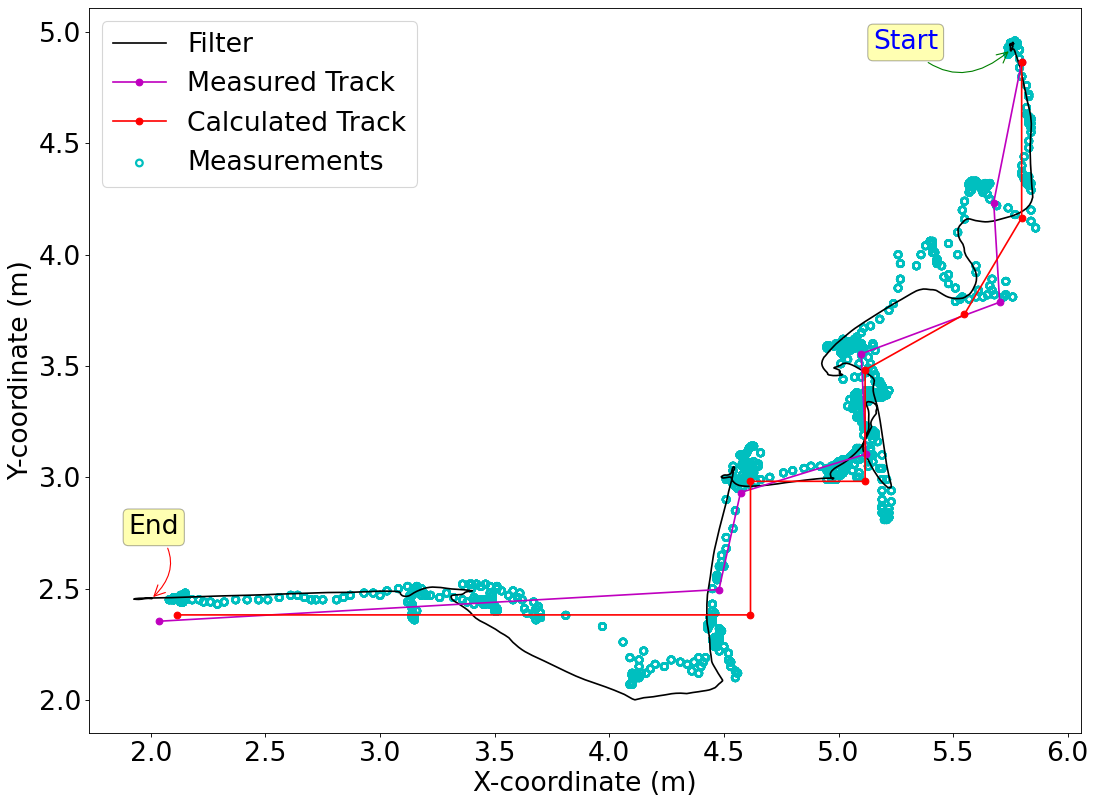

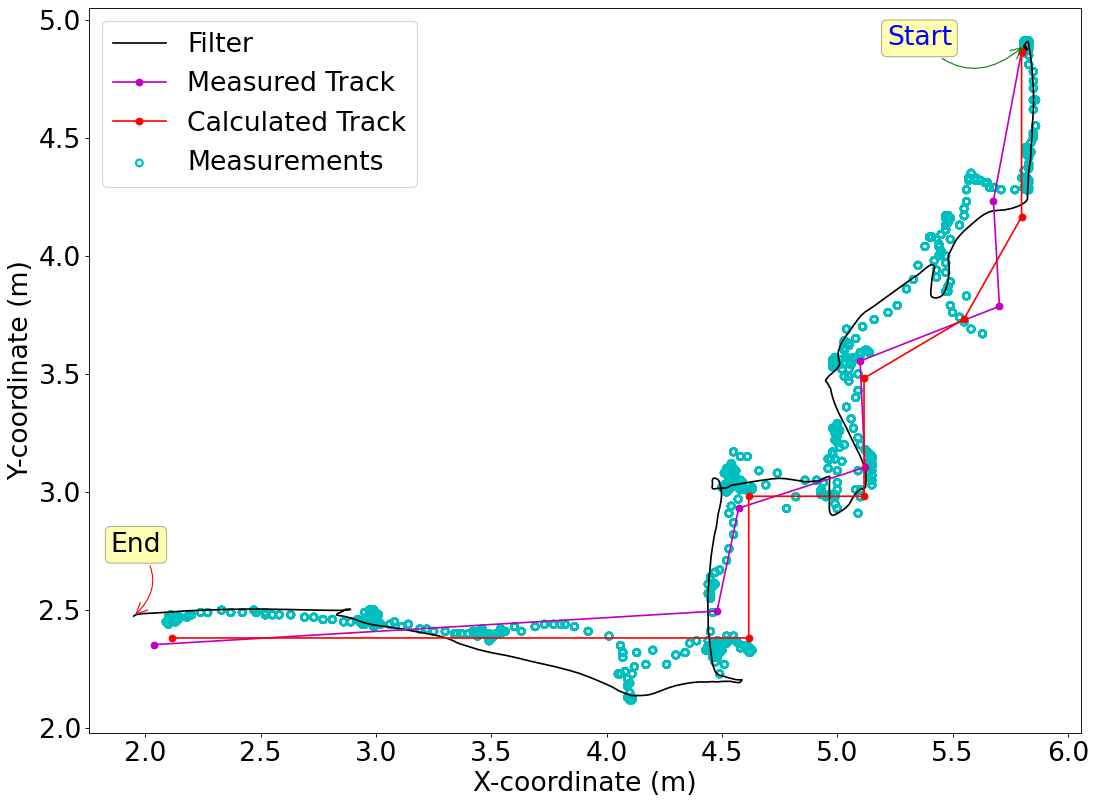

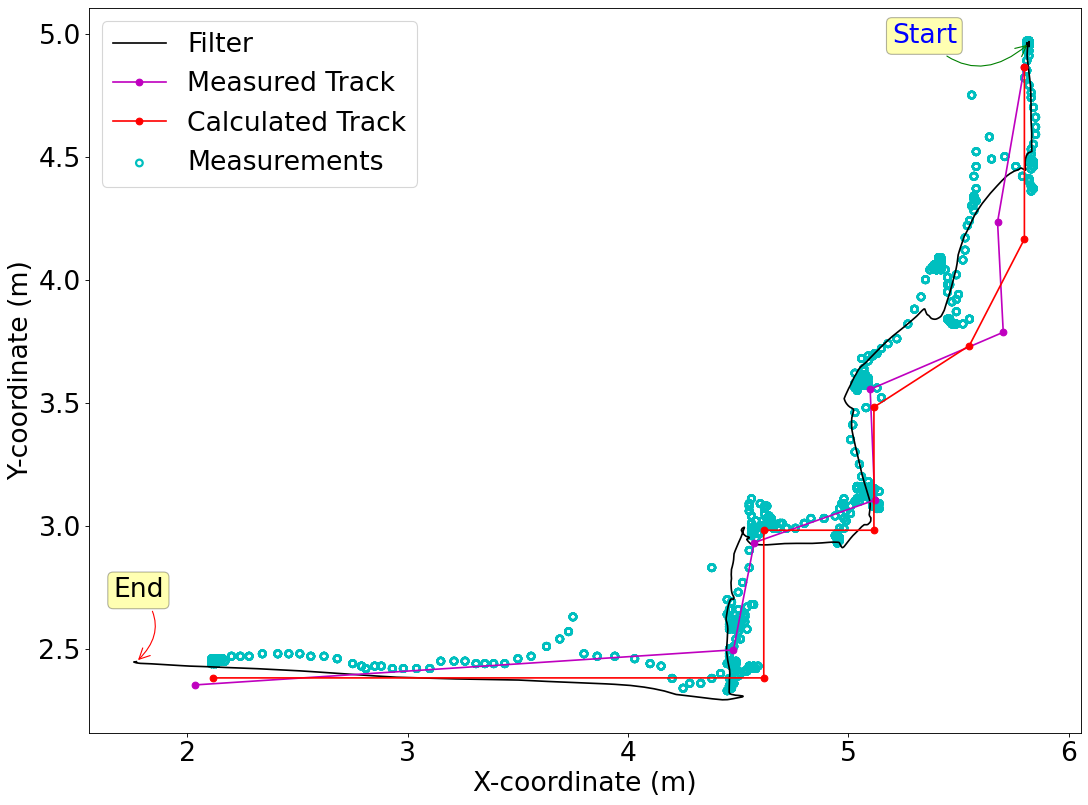

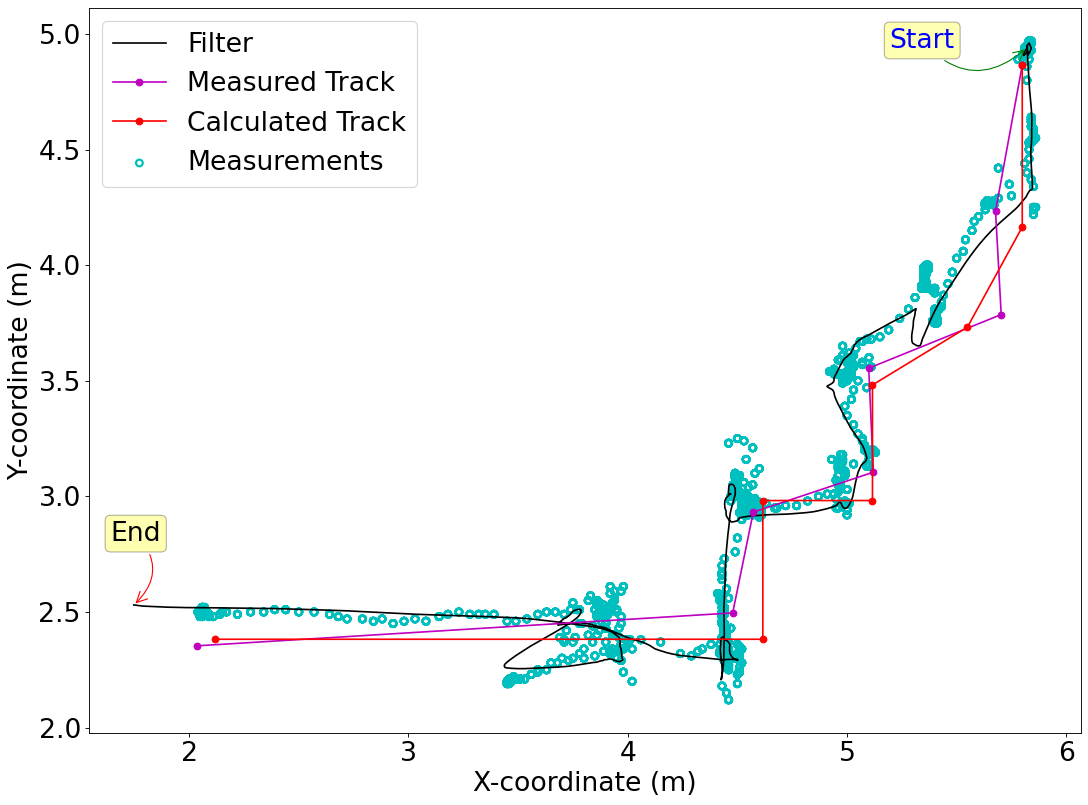

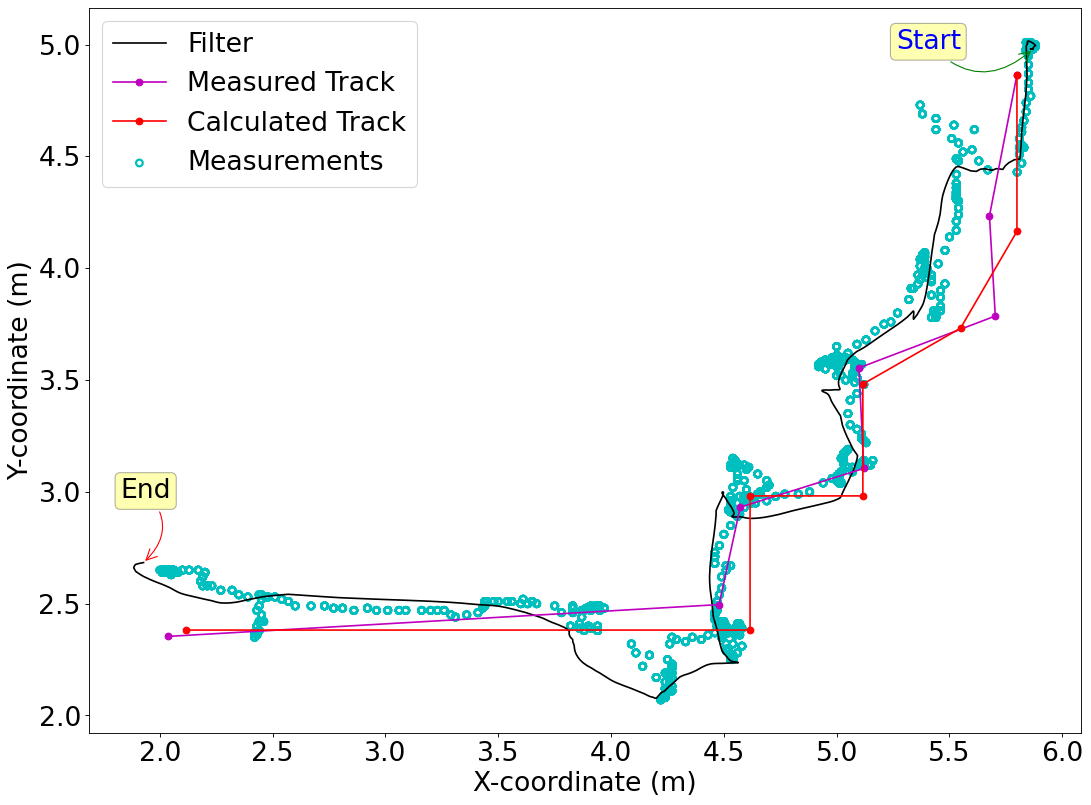

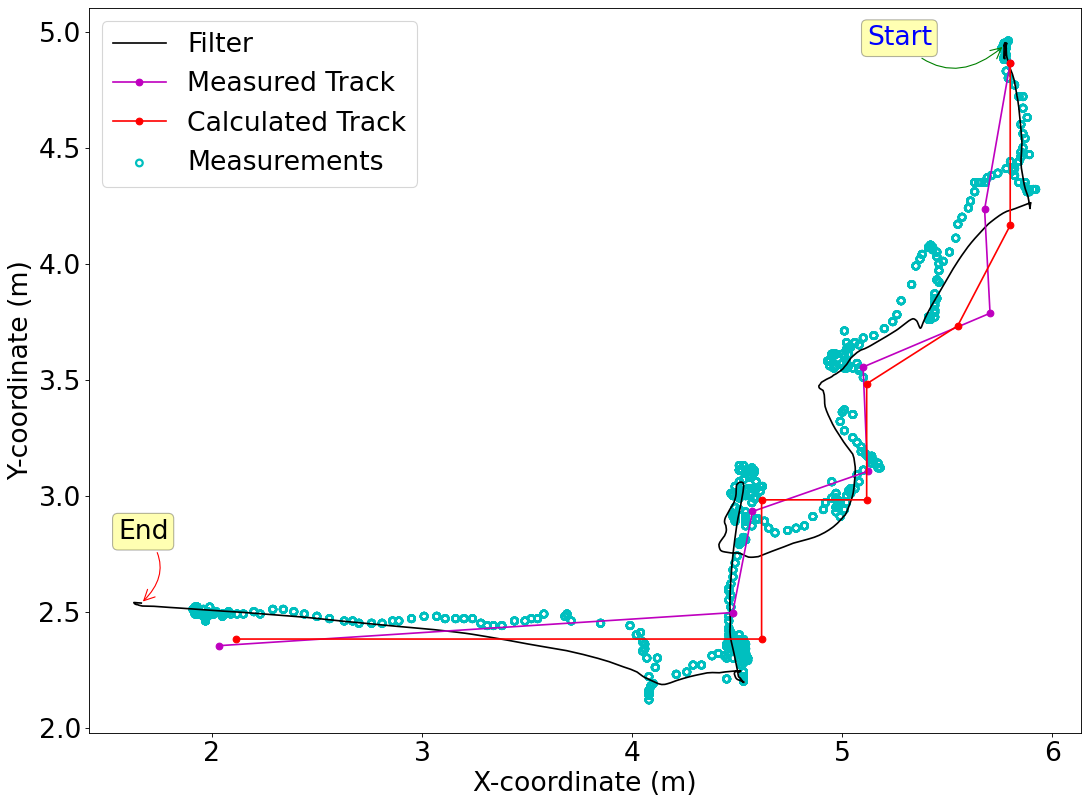

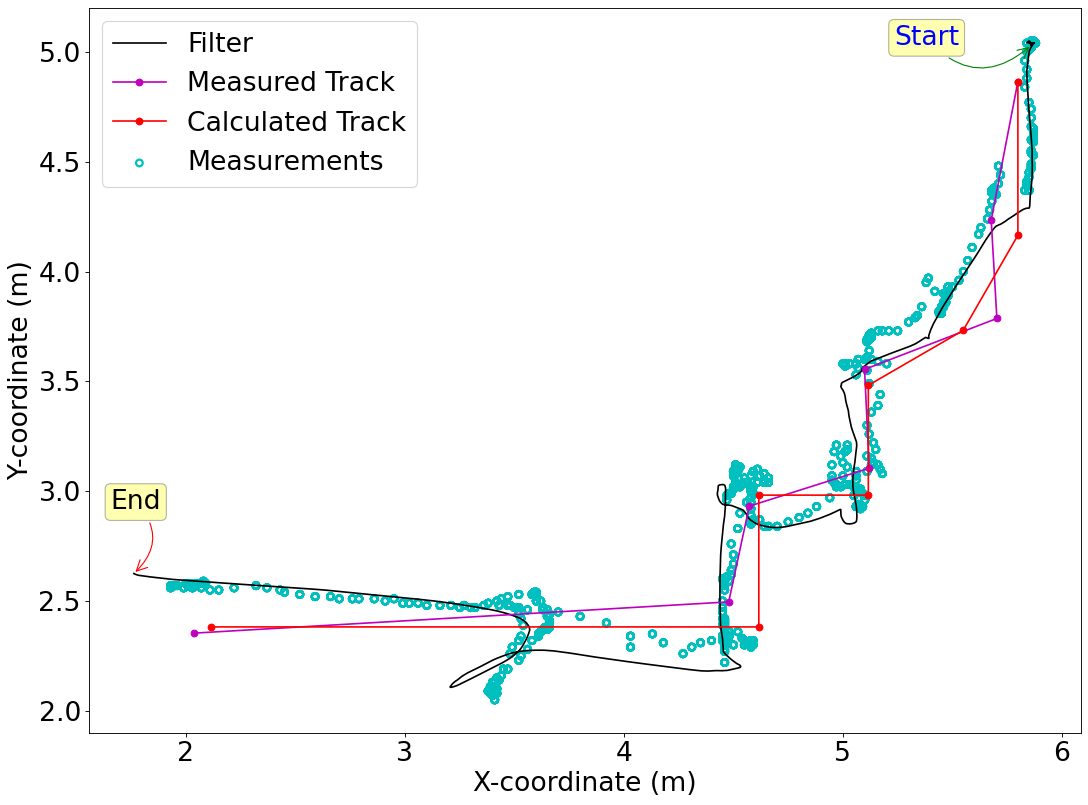

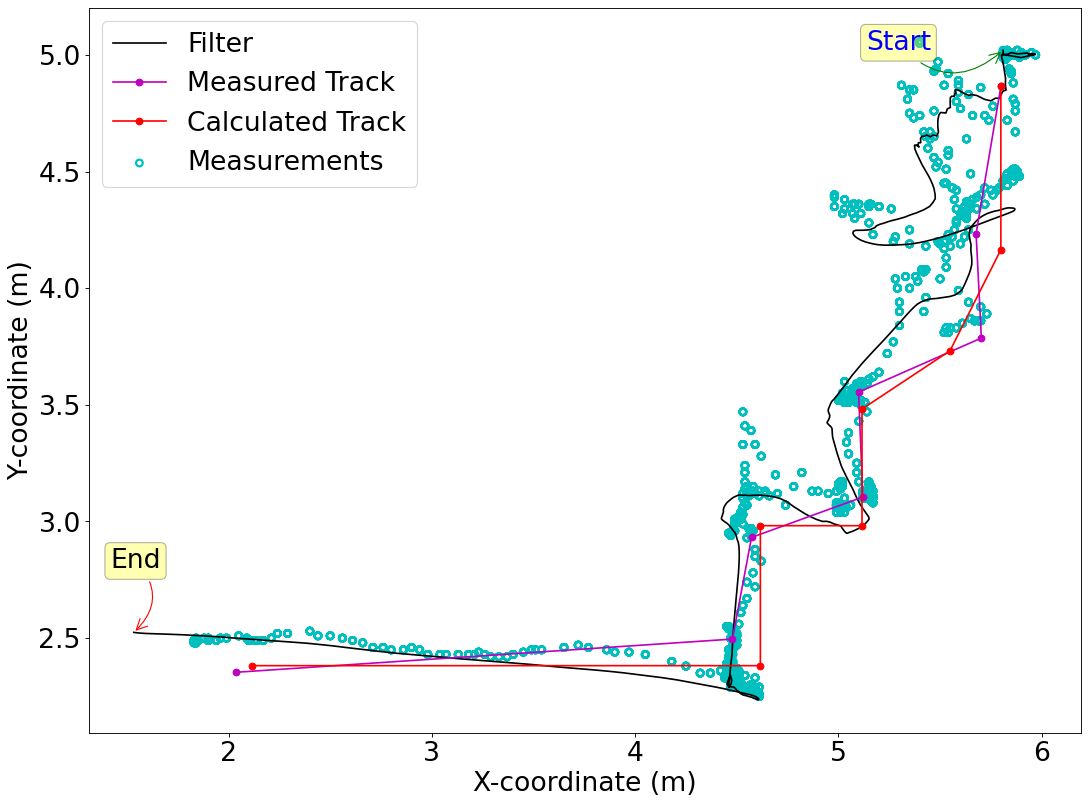

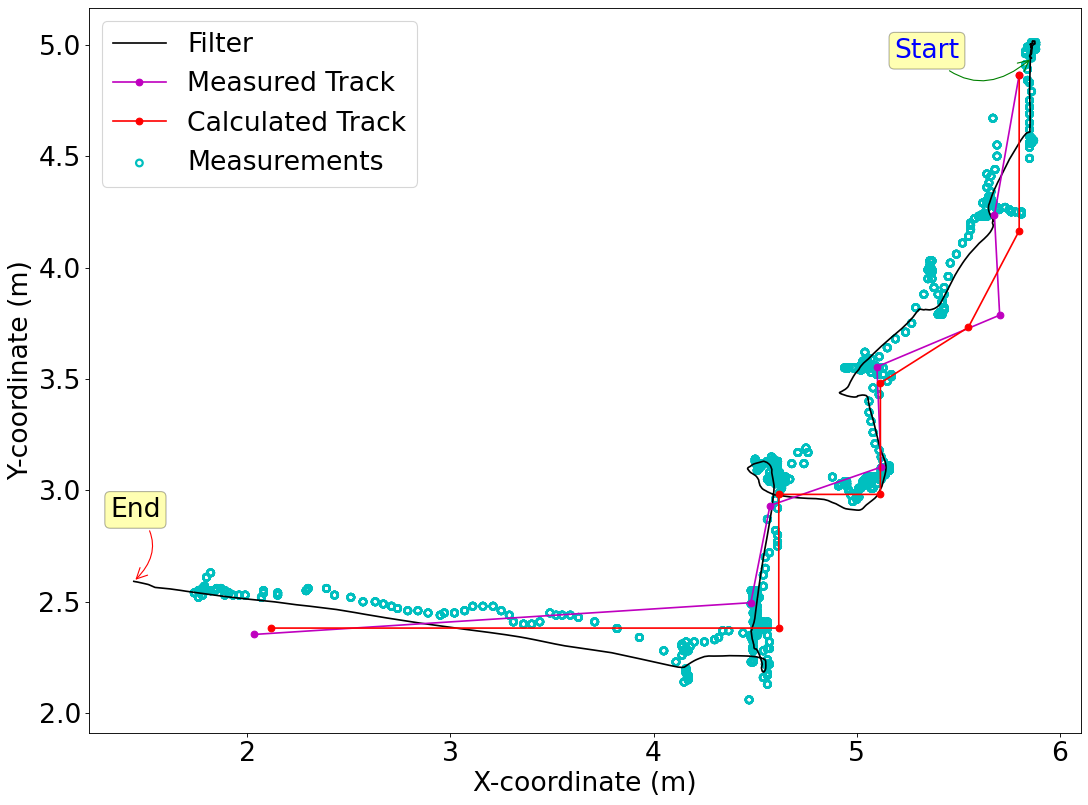

In [105]:
# generate plot for all experiments
for i in range(2, 11):
    generate(i)

In [111]:
print(f"mean = {np.mean(error)} m, variance = {statistics.variance(error)} m\u00b2")

mean = 0.24249670463171374 m, variance = 0.033868014433167205 m²
